## Neural Style Transfer

In [1]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import IPython.display as display

### To test style transfer code we will use:
## Le jardin de l'artiste à Giverny de Claude Monet

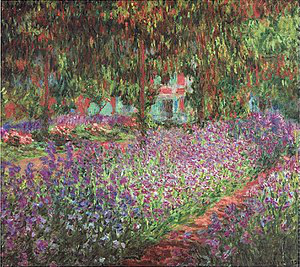

In [22]:
Image.open("style_image.jpg")
#plt.plot(img) not working

In [10]:
img = tf.io.read_file("style_image.jpg")
img = tf.image.decode_image(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
shape = tf.cast(tf.shape(img)[:-1], tf.float32)
long_dim = max(shape)
scale = 512 / long_dim
scale

<tf.Tensor: shape=(), dtype=float32, numpy=1.7066667>

In [23]:
img = tf.io.read_file("style_image.jpg")
img = tf.image.decode_image(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
shape = tf.cast(tf.shape(img)[:-1], tf.float32)
long_dim = max(shape)
scale = 512 / long_dim

new_shape = tf.cast(shape * scale, tf.int32)

img = tf.image.resize(img, new_shape)
img = img[tf.newaxis, :]

In [3]:
image = tf.keras.preprocessing.image.load_img("content_image.jpg", color_mode = "grayscale", target_size = None)

In [24]:
content_img = tf.io.read_file("content_image.jpg")
content_img = tf.image.decode_image(content_img, channels=3)
content_img = tf.image.convert_image_dtype(content_img, tf.float32)
shape = tf.cast(tf.shape(content_img)[:-1], tf.float32)
long_dim = max(shape)
scale = 512 / long_dim

new_shape = tf.cast(shape * scale, tf.int32)

content_img = tf.image.resize(content_img, new_shape)
content_img = content_img[tf.newaxis, :]

In [11]:
#https://arxiv.org/pdf/1409.1556.pdf
"""The default input size for this model is 224x224."""
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights = "imagenet")
vgg.trainable = False
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layer = ['block5_conv2']

style_layers = ["block1_conv1", 
                "block2_conv1", 
                "block3_conv1", 
                "block4_conv1", 
                "block5_conv1"]

dims_content = len(content_layer)
dims_style = len(style_layers)

In [27]:
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)
output_style = model(img*255)

In [28]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [29]:
#define the gram  matrix function
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return(result/(num_locations))

## Extract Style and Content

In [30]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layer):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layer)
        self.style_layers = style_layers
        self.content_layer = content_layer
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layer, content_outputs)}
        
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [31]:
extractor = StyleContentModel(style_layers, content_layer)

results = extractor(tf.constant(content_img))

In [32]:
style_targets = extractor(img)["style"]
content_targets = extractor(content_img)["content"]

In [33]:
image = tf.Variable(content_img)

In [34]:
#keep pixel value between 0 and 1
def clip_0_1(image):
    return(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [35]:
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.9, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / dims_style

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / dims_content
    loss = style_loss + content_loss
    return(loss)

In [37]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [38]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

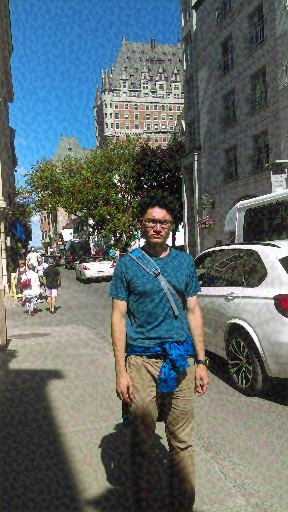

In [39]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

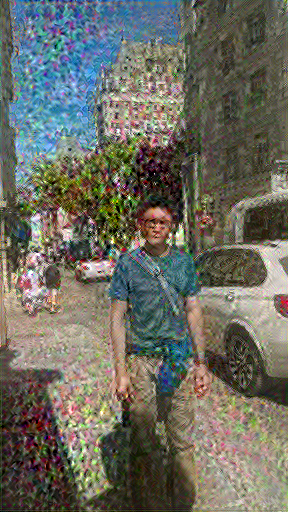

Train step: 1000
Total time: 2423.1


In [40]:
#keep track of time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))